In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Data Generation
===

In [4]:
np.random.seed(10)
p, q = (np.random.rand(i, 2) for i in (4, 5))
p_big, q_big = (np.random.rand(i, 80) for i in (100, 120))

print(p, "\n\n", q)


[[ 0.77132064  0.02075195]
 [ 0.63364823  0.74880388]
 [ 0.49850701  0.22479665]
 [ 0.19806286  0.76053071]] 

 [[ 0.16911084  0.08833981]
 [ 0.68535982  0.95339335]
 [ 0.00394827  0.51219226]
 [ 0.81262096  0.61252607]
 [ 0.72175532  0.29187607]]


Solution
===

In [42]:
def naive(p, q):
    D = np.zeros([p.shape[0], q.shape[0]])
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            D[i,j] = (p[i, 0] - q[j, 0])**2 + (p[i, 1] - q[j, 1])**2
    D = np.sqrt(D)
    return D

### Use matching indices

Instead of iterating through indices, one can use them directly to parallelize the operations with Numpy.

In [6]:
rows, cols = np.indices((p.shape[0], q.shape[0]))
print(rows, end='\n\n')
print(cols)
print(np.indices((p.shape[0], q.shape[0])).shape)
print(rows.ravel())
print(cols.ravel())

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
(2, 4, 5)
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]


In [7]:
print(p[rows.ravel()], end='\n\n')
print(q[cols.ravel()])

[[ 0.77132064  0.02075195]
 [ 0.77132064  0.02075195]
 [ 0.77132064  0.02075195]
 [ 0.77132064  0.02075195]
 [ 0.77132064  0.02075195]
 [ 0.63364823  0.74880388]
 [ 0.63364823  0.74880388]
 [ 0.63364823  0.74880388]
 [ 0.63364823  0.74880388]
 [ 0.63364823  0.74880388]
 [ 0.49850701  0.22479665]
 [ 0.49850701  0.22479665]
 [ 0.49850701  0.22479665]
 [ 0.49850701  0.22479665]
 [ 0.49850701  0.22479665]
 [ 0.19806286  0.76053071]
 [ 0.19806286  0.76053071]
 [ 0.19806286  0.76053071]
 [ 0.19806286  0.76053071]
 [ 0.19806286  0.76053071]]

[[ 0.16911084  0.08833981]
 [ 0.68535982  0.95339335]
 [ 0.00394827  0.51219226]
 [ 0.81262096  0.61252607]
 [ 0.72175532  0.29187607]
 [ 0.16911084  0.08833981]
 [ 0.68535982  0.95339335]
 [ 0.00394827  0.51219226]
 [ 0.81262096  0.61252607]
 [ 0.72175532  0.29187607]
 [ 0.16911084  0.08833981]
 [ 0.68535982  0.95339335]
 [ 0.00394827  0.51219226]
 [ 0.81262096  0.61252607]
 [ 0.72175532  0.29187607]
 [ 0.16911084  0.08833981]
 [ 0.68535982  0.95339335]

In [43]:
def with_indices(p, q):
    rows, cols = np.indices((p.shape[0], q.shape[0]))
    D = np.linalg.norm(p[rows.ravel(), :] - q[cols.ravel(), :], axis=1)
    return np.reshape(D, [p.shape[0], q.shape[0]])

D = naive(p, q)
D2 = with_indices(p, q)
print(D)
print(D2)


np.allclose(D,D2)

[[ 0.60599073  0.93659449  0.91124856  0.59321356  0.27561751]
 [ 0.80746999  0.21102354  0.67268649  0.22495084  0.46534491]
 [ 0.35654215  0.75217493  0.57200052  0.49900068  0.23310825]
 [ 0.67281411  0.52407472  0.31520226  0.63212897  0.70277376]]
[[ 0.60599073  0.93659449  0.91124856  0.59321356  0.27561751]
 [ 0.80746999  0.21102354  0.67268649  0.22495084  0.46534491]
 [ 0.35654215  0.75217493  0.57200052  0.49900068  0.23310825]
 [ 0.67281411  0.52407472  0.31520226  0.63212897  0.70277376]]


True

### Use a library

`scipy` is the equivalent of matlab toolboxes and have a lot to offer. Actually the pairwise computation is part of the library through the `spatial` module.

In [45]:
from scipy.spatial.distance import cdist

def scipy_version(p, q):
    return cdist(p, q)

### Numpy Magic

In [46]:
def tensor_broadcasting(p, q):
    return np.sqrt(np.sum((p[:,np.newaxis,:]-q[np.newaxis,:,:])**2, axis=2))

# Compare methods

In [47]:
methods = [naive, with_indices, scipy_version, tensor_broadcasting]
timers = []
for f in methods:
    r = %timeit -o f(p_big, q_big)
    timers.append(r)


10 loops, best of 3: 21 ms per loop
100 loops, best of 3: 11.5 ms per loop
1000 loops, best of 3: 1.06 ms per loop
100 loops, best of 3: 6.6 ms per loop


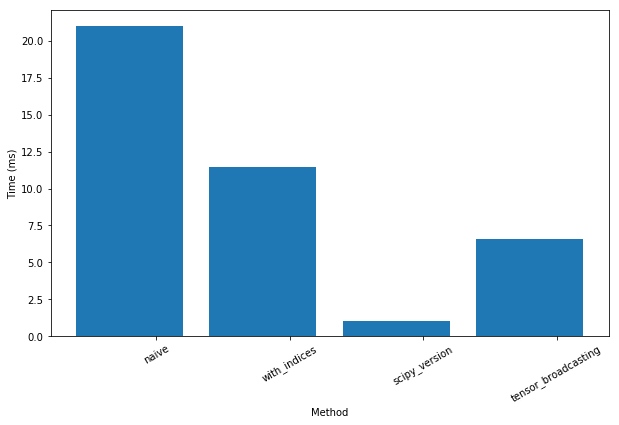

In [48]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(methods)), [r.best*1000 for r in timers], log=False)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods))+0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel('Method')
plt.ylabel('Time (ms)')
plt.show()